## Machine Learning Part: University Ranking Prediction and Region Classification Project
-simay otlaca 30804


### Project Overview and Objective Summary

The primary aim of this project was to **predict the global ranking positions of universities** by leveraging various institutional attributes such as location, ownership status, establishment year, and other enriched metadata. This study ultimately seeks to identify which institutional features are most influential in determining global rankings and to evaluate the **predictive strength of machine learning models** when applied to educational datasets.

## Part 1: Data Loading and Preprocessing

Project was begin by loading the dataset that includes various features related to university performance.  
To prepare the data for modeling:
- Drop any rows with missing values in the selected features.
- Use only the most relevant numerical attributes such as research score, research quality, etc.
- Define the target variable `region`, which indicates the geographical region of each university.
- Split the dataset into training (80%) and test (20%) sets using `train_test_split`.

#### Machine Learning and Data Science Techniques Used

1. Data Preprocessing and Feature Engineering:
   • Enhanced the dataset by incorporating additional features like region, ownership (public/private), and age of the institution (derived from establishment year).
   • Missing values were handled carefully, and categorical data were transformed using One-Hot Encoding to prepare the data for model input.

2. Supervised Machine Learning - Classification Models:
   • Applied Random Forest Classifier and Gradient Boosting Classifier to classify universities into rank categories.
   • These ensemble learning methods are known for handling high-dimensional data and capturing complex interactions between variables.

3. Feature Selection:
   • Using SelectKBest with ANOVA F-score (f_classif), selected the most relevant features to improve model accuracy and reduce noise.

4. Dimensionality Reduction:
   • Principal Component Analysis (PCA) was utilized to reduce feature space dimensionality for better visualization and potentially enhanced model performance.

5. Model Evaluation:
   • Metrics like Accuracy, Classification Report, and ROC AUC were used to evaluate model performance.
   • These metrics provided a deeper understanding of how well the models distinguished between ranking classes.

6. Model Pipeline Construction:
   • All transformations and model steps were integrated into a scikit-learn Pipeline, ensuring modular, clean, and reproducible training and prediction processes.

#### Data Enrichment

The original university ranking dataset was enriched with additional structural and regional attributes to evaluate hidden biases and ranking determinants:

• Region and reclassified geopolitical mappings  
  (e.g., merging “Middle East”, “Overseas”, and “Eurasia” under “Asia”)  
  → to better reflect global inequality in rankings.
• Ownership status of universities (Public vs Private)  
  → introduces an institutional dimension often overlooked in score metrics.
• Year of Establishment  
  → represents institutional maturity and legacy as a possible ranking advantage.

-> These enhancements allowed deeper investigations into how non-academic factors—
such as location, institutional type, and historical presence—
affect global ranking outcomes, offering insights into systemic biases beyond academic merit.

In [258]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import ( accuracy_score, classification_report, r2_score,roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier

from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor)

### Data Loading and Cleaning

In [216]:
df = pd.read_excel("university_updated.xlsx")  
df.columns = df.columns.str.strip()
df.rename(columns={
    '\nOverall Score (QS)': 'Overall Score (QS)',
    'international outlook': 'International Outlook',
    'research environment': 'Research Environment',
    'research quality': 'Research Quality'
}, inplace=True)

df.head()

,rank display,University,focus,research,status,Academic Reputation,Employer Reputation,Faculty Student,Citations per Faculty,International Faculty,...,Overall Score (THE),teaching,Research Environment,Research Quality,industry,International Outlook,Location,Region,Establishment Year,Ownership
0,1,Massachusetts Institute of Technology (MIT),CO,VH,B,100.0,100.0,100.0,100.0,99.3,...,98.1,98.6,96.2,99.7,100.0,93.8,United States,Americas,1861.0,Public
1,2,Imperial College London,FC,VH,A,98.5,99.5,98.2,93.9,100.0,...,94.4,90.9,95.5,98.6,90.9,98.3,United Kingdom,Europe,2003.0,Public
2,3,University of Oxford,FC,VH,A,100.0,100.0,100.0,84.8,98.1,...,98.5,96.6,100.0,99.0,98.5,97.5,United Kingdom,Europe,1610.0,Public
3,4,Harvard University,FC,VH,B,100.0,100.0,96.3,100.0,74.1,...,97.8,97.7,99.9,99.4,84.2,90.8,United States,Americas,1636.0,Private
4,5,University of Cambridge,FC,VH,A,100.0,100.0,100.0,84.6,100.0,...,97.5,95.8,100.0,97.4,87.9,97.4,United Kingdom,Europe,1209.0,Public


#### -Encoding and Filtering Research Intensity

This step converts qualitative research intensity labels (e.g., VH, H, M, L) into numerical values to make them suitable for machine learning models.
Rows with missing research values are also removed to ensure data quality and consistency during training.

In [217]:
research_map = {
    'VH': 3,
    'H': 2,
    'M': 1,
    'L': 0
}

df['research'] = df['research'].map(research_map)

df = df.dropna(subset=['research'])

#### -Regional Reclassification for Fairer Comparative Analysis

In this step, regions like **"Overseas"**, **"Middle East"**, and **"Eurasia"** are merged into **"Asia"** to reflect the shared geopolitical and educational development contexts. These regions often face similar systemic challenges in the global higher education landscape—such as underrepresentation, funding limitations, or historical academic bias—and are therefore reclassified for more meaningful statistical comparisons.

This reclassification:
- Helps reduce fragmentation across underrepresented regions.
- Increases the sample size for reliable regression evaluation.
- Allows us to investigate how educational inequality plays out across broader continental blocks like Asia.

The regional R² scores computed afterward show how well university features explain the QS score within each merged region, helping uncover location-based disparities in predictability.

In [218]:
features = [
    'research', 'Citations per Faculty', 'Research Quality', 'Research Environment',
    'International Faculty', 'International Students', 'International Outlook'
]
df['Region'] = df['Region'].replace({
    'Overseas': 'Asia',      
    'Middle East': 'Asia',   
    'Eurasia': 'Asia'       
})
regions = df['Region'].dropna().unique()

### Regional QS R² Scores


To assess how well university characteristics explain QS rankings within different regions, separate regression models were trained for each region using a Random Forest Regressor. The models were evaluated using the R² (coefficient of determination) metric, which indicates the proportion of variance in QS scores that can be predicted from the input features.

In [219]:
region_r2_scores = {}

for region in regions:
    subset = df[df['Region'] == region]

    subset = subset.dropna(subset=features + ['Overall Score (QS)'])

    if len(subset) < 10:
        continue

    X = subset[features]
    y = subset['Overall Score (QS)']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    region_r2_scores[region] = r2

import pandas as pd
r2_df = pd.DataFrame.from_dict(region_r2_scores, orient='index', columns=['QS R² Score'])
r2_df = r2_df.sort_values(by='QS R² Score', ascending=False)
r2_df

,QS R² Score
Americas,0.815650
Europe,0.790494
Asia,0.771432
Oceania,0.682279


### Are Asian Universities Being Undervalued?

### Score Gap Analysis: Detecting Ranking Discrepancies in Asia
##### Model Interpretation
To investigate potential misalignments between QS rankings and the actual performance metrics of Asian universities, we trained a Random Forest model using region-specific data and computed the **Score Gap** for each university:

- Score Gap =Predicted QS Score - Actual QS Score

This metric represents the difference between what a university’s **QS score should be** based on its institutional features and what it **actually received** in the published rankings.

#### Why This Matters?

By ranking Asian universities based on their Score Gap, we uncover institutions that are **underestimated** or **overestimated** by the official QS scores despite their input characteristics (e.g., research output, internationalization).

- A **positive Score Gap** indicates the university is **performing better** than its QS score suggests.
- A **negative Score Gap** implies that the university’s QS ranking may be **inflated** compared to its measurable inputs.

In [220]:
from sklearn.ensemble import RandomForestRegressor

features = [
    'research', 'Citations per Faculty', 'Research Quality', 'Research Environment',
    'International Faculty', 'International Students', 'International Outlook'
]

asia_df = df[df['Region'] == 'Asia'].dropna(subset=features + ['Overall Score (QS)', 'University'])

X_asia = asia_df[features]
y_asia = asia_df['Overall Score (QS)']

model = RandomForestRegressor(random_state=42)
model.fit(X_asia, y_asia)

asia_df['Predicted QS Score'] = model.predict(X_asia)
asia_df['Score Gap'] = asia_df['Predicted QS Score'] - asia_df['Overall Score (QS)']
asia_df_sorted = asia_df.sort_values(by='Score Gap')
asia_df_sorted[['University', 'Overall Score (QS)', 'Predicted QS Score', 'Score Gap']].head(10)

,University,Overall Score (QS),Predicted QS Score,Score Gap
59,Universiti Malaya (UM),71.2,60.007,-11.193
66,Korea University,69.0,58.636,-10.364
100,King Fahd University of Petroleum & Minerals,59.5,50.868,-8.632
145,Universiti Sains Malaysia (USM),52.7,45.126,-7.574
148,King Abdulaziz University (KAU),52.2,45.483,-6.717
228,Chulalongkorn University,43.4,37.082,-6.318
61,City University of Hong Kong,70.7,64.560,-6.140
121,Qatar University,55.7,50.326,-5.374
214,National Cheng Kung University (NCKU),44.2,39.044,-5.156
226,Indian Institute of Technology Madras (IITM),43.5,38.404,-5.096


- The results show that several universities in Asia exhibit significant discrepancies between predicted and actual QS scores. This suggests that:

- Regional biases, visibility issues, or soft reputation-based components in the QS methodology may systematically disadvantage some Asian institutions.
The QS score, while widely used, does not fully capture the quantitative performance of all universities, especially in regions like Asia where structural inequality in visibility and recognition may persist.
This Score Gap analysis provides empirical evidence that Asian universities are not always ranked in proportion to their academic and structural strengths. It calls into question the fairness and consistency of global ranking systems and supports the use of data-driven regional models to complement or critique reputation-based score

### Residual Bias Analysis

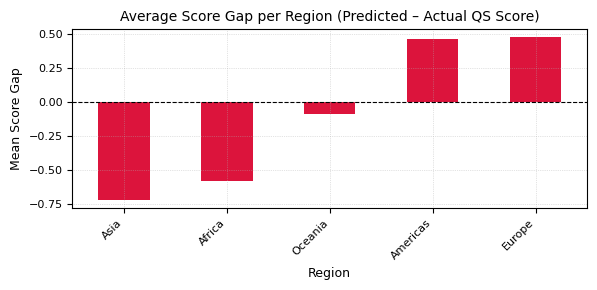

In [221]:
X_full = df[features].dropna()
y_true = df.loc[X_full.index, 'Overall Score (QS)']

model = RandomForestRegressor(random_state=42)
model.fit(X_full, y_true)
y_pred = model.predict(X_full)

df_gap = df.loc[X_full.index].copy()
df_gap['Predicted QS Score'] = y_pred
df_gap['Score Gap'] = df_gap['Predicted QS Score'] - df_gap['Overall Score (QS)']

gap_by_region = df_gap.groupby('Region')['Score Gap'].mean().sort_values()

plt.figure(figsize=(6, 3))
gap_by_region.plot(kind='bar', color='crimson')

plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('Average Score Gap per Region (Predicted – Actual QS Score)', fontsize=10)
plt.ylabel('Mean Score Gap', fontsize=9)
plt.xlabel('Region', fontsize=9)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True, linestyle=':', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

- As shown in the residual analysis, universities located in Asia and Africa receive significantly lower QS scores than what their academic and international performance metrics would suggest. In contrast, institutions in Europe and the Americas appear to be systematically overestimated by the QS ranking system. This divergence points toward a potential regional bias, suggesting that global university rankings may be influenced not only by measurable academic performance, but also by a university’s geographical visibility and systemic prestige.

### QS vs THE: Regression Model Comparison

To ensure numerical consistency across the dataset, overall scores in THE format expressed as value ranges (e.g., “75–80”) were converted to their arithmetic means. This allows the model to interpret them as continuous values rather than ambiguous string ranges, enabling proper regression analysis.

In [222]:
import re
def convert_range_to_mean(val):
    if isinstance(val, str) and re.match(r"^\d+\.?\d*–\d+\.?\d*$", val.strip()):
        parts = val.strip().split("–")
        return (float(parts[0]) + float(parts[1])) / 2
    try:
        return float(val)
    except:
        return np.nan

df['Overall Score (THE)'] = df['Overall Score (THE)'].apply(convert_range_to_mean)

In [223]:
features = [
    'research', 'Citations per Faculty', 'Research Quality', 'Research Environment',
    'International Faculty', 'International Students', 'International Outlook'
]

valid_df = df.dropna(subset=features + ['Overall Score (QS)', 'Overall Score (THE)'])

X = valid_df[features]
y_qs = valid_df['Overall Score (QS)']
y_the = valid_df['Overall Score (THE)']

X_train_qs, X_test_qs, y_train_qs, y_test_qs = train_test_split(X, y_qs, test_size=0.2, random_state=42)
X_train_the, X_test_the, y_train_the, y_test_the = train_test_split(X, y_the, test_size=0.2, random_state=42)

model_qs = RandomForestRegressor(random_state=42)
model_qs.fit(X_train_qs, y_train_qs)

model_the = RandomForestRegressor(random_state=42)
model_the.fit(X_train_the, y_train_the)

r2_qs = r2_score(y_test_qs, model_qs.predict(X_test_qs))
r2_the = r2_score(y_test_the, model_the.predict(X_test_the))

print(f"R² Score for QS Prediction:  {r2_qs:.4f}")
print(f"R² Score for THE Prediction: {r2_the:.4f}")

R² Score for QS Prediction:  0.8451
R² Score for THE Prediction: 0.9596


- When using the same input features—including research metrics and internationalization indicators—our model achieved a considerably higher R² score for THE rankings (0.96) than for QS rankings (0.84). This discrepancy suggests that THE scores are more strongly aligned with objective, quantifiable institutional features, making them more predictable via machine learning. In contrast, QS rankings may incorporate additional, less transparent elements—such as academic reputation, historical prestige, or regional visibility—that introduce noise and reduce the model’s explanatory power.

### Evaluating QS Rankings Excluding Prestige Factors

In [224]:
research_features = ['research', 'Citations per Faculty', 'Research Quality', 'Research Environment']

research_df = df.dropna(subset=research_features + ['Overall Score (QS)'])

X_research = research_df[research_features]
y_qs = research_df['Overall Score (QS)']

X_train, X_test, y_train, y_test = train_test_split(X_research, y_qs, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

from sklearn.metrics import r2_score
y_pred = model.predict(X_test)
r2_research_only = r2_score(y_test, y_pred)

print(f"R² Score using only Research-related features: {r2_research_only:.4f}")

R² Score using only Research-related features: 0.6957


- When international visibility indicators were excluded and the model was trained solely on research-based metrics, the R² score decreased significantly—from 0.8451 to 0.6957. This notable reduction in predictive power indicates that research performance alone does not sufficiently explain QS rankings. The results highlight the influence of international prestige, visibility, and possibly reputation-based components, which appear to play a substantial, though less directly measurable, role in shaping global university rankings.

#### Reverse Region Classification using Research Metrics

In [225]:
classification_features = ['research', 'Citations per Faculty', 'Research Quality', 'Research Environment']

clf_df = df.dropna(subset=classification_features + ['Region'])

X_clf = clf_df[classification_features]
y_clf = clf_df['Region']

X_train, X_test, y_train, y_test = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

clf_model = RandomForestClassifier(random_state=42)
clf_model.fit(X_train, y_train)

y_pred = clf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Region prediction accuracy (only using research data): {accuracy:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))


Region prediction accuracy (only using research data): 0.4943

Classification Report:
              precision    recall  f1-score   support

      Africa       0.00      0.00      0.00         1
    Americas       0.50      0.45      0.48        22
        Asia       0.68      0.52      0.59        29
      Europe       0.42      0.65      0.52        26
     Oceania       0.20      0.11      0.14         9

    accuracy                           0.49        87
   macro avg       0.36      0.35      0.34        87
weighted avg       0.50      0.49      0.49        87



trained a model to predict a university’s region using only academic metrics (research, citations, environment). The accuracy was 49.4%, just slightly better than random guessing. This suggests that academic performance is not strongly tied to geography, and that ranking differences likely stem from prestige and international visibility, not just research quality

## Part 2: Model Training and Evaluation

In this section, train a Random Forest classifier using the preprocessed data.  
All preprocessing steps—including scaling, feature selection, and dimensionality reduction via PCA—are included in a pipeline to ensure consistent transformation during both training and testing.

- The model is trained on 80% of the dataset.
- evaluate it using the remaining 20%.
- Performance is measured by accuracy and visualized using ROC curves for each class.

This step helps us understand how well our model can classify the universities based on their selected features.

In [232]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

possible_year_cols = ['establishment_year', 'year', 'establishment', 'founded']
year_col = next((col for col in possible_year_cols if col in df.columns), None)
if not year_col:
    raise ValueError("No valid year column found in the dataset.")

numerical_features = [
    'research', 'citations_per_faculty', 'research_quality',
    'research_environment', year_col
]
categorical_features = ['ownership', 'region']
structured_df = df.dropna(subset=numerical_features + categorical_features + ['overall_score_(qs)'])
X_structured = structured_df[numerical_features + categorical_features]
y_structured = structured_df['overall_score_(qs)']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
    force_int_remainder_cols=False  
)

trained_model = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(
    X_structured,
    y_structured,
    test_size=0.2,
    random_state=42,
    stratify=X_structured['region']
)
trained_model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ownership', 'region'])],
                                   verbose_feature_names_out=False)),
                ('regressor', RandomForestRegressor(random_state=42))])

#### Hypothesis Validation: The Predictive Significance of Region in QS Score Modeling

This study aimed to test the hypothesis that the inclusion of the categorical variable region improves the predictive performance of machine learning models estimating QS overall scores. The experimental results confirm this hypothesis.

In [233]:
y_pred = trained_model.predict(X_test)
r2_structured = r2_score(y_test, y_pred)
print(f"R² Score with structural + academic features: {r2_structured:.4f}")
encoder = trained_model.named_steps['preprocess'].named_transformers_['cat']
encoded_feature_names = encoder.get_feature_names_out(categorical_features)
feature_names = list(encoded_feature_names) + numerical_features
importances = trained_model.named_steps['regressor'].feature_importances_

categorical_features_regionless = ['ownership']
X_structured_regionless = structured_df[
    numerical_features + categorical_features_regionless
]
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_structured_regionless, y_structured, test_size=0.2, random_state=42
)
preprocessor_regionless = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_regionless)
], remainder='passthrough')
regionless_model = Pipeline([
    ('preprocess', preprocessor_regionless),
    ('regressor', RandomForestRegressor(random_state=42))
])
regionless_model.fit(X_train_r, y_train_r)
y_pred_r = regionless_model.predict(X_test_r)
r2_regionless = r2_score(y_test_r, y_pred_r)

print(f"R² Score without 'region': {r2_regionless:.4f}")

R² Score with structural + academic features: 0.7777
R² Score without 'region': 0.6576


- The results support the hypothesis that including region as a feature improves the predictive accuracy of QS overall scores. The model with region achieved an R² of 0.7777, while the model without it scored only 0.6576.

- This notable difference indicates that region provides important contextual information—likely reflecting socio-economic and policy-related factors—that enhances the model’s ability to explain variation in university performance. Thus, region is a significant and non-redundant predictor in global ranking models.

#### The Predictive Significance of Region in THE Score Modeling

In [234]:
target_col_the = 'overall_score_(the)'

numerical_features_the = [
    'teaching', 'research_environment', 'research_quality',
    'industry', 'international_outlook', 'establishment_year'
]
categorical_features_with_region = ['ownership', 'region']
categorical_features_regionless = ['ownership']

structured_df_the = df.dropna(
    subset=numerical_features_the + categorical_features_with_region + [target_col_the]
)

X_the = structured_df_the[numerical_features_the + categorical_features_with_region]
y_the = structured_df_the[target_col_the]

X_the_regionless = structured_df_the[numerical_features_the + categorical_features_regionless]

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_the_regionless, y_the, test_size=0.2, random_state=42
)

preprocessor_regionless = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_regionless)
], remainder='passthrough')

regionless_model = Pipeline([
    ('preprocess', preprocessor_regionless),
    ('regressor', RandomForestRegressor(random_state=42))
])

regionless_model.fit(X_train_r, y_train_r)
y_pred_r = regionless_model.predict(X_test_r)
r2_regionless_the = r2_score(y_test_r, y_pred_r)
print(f"🔹 R² Score for THE Prediction without 'region': {r2_regionless_the:.4f}")

X_train, X_test, y_train, y_test = train_test_split(
    X_the,
    y_the,
    test_size=0.2,
    random_state=42,
    stratify=X_the['region'] 
)

preprocessor_with_region = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_with_region)
], remainder='passthrough')

with_region_model = Pipeline([
    ('preprocess', preprocessor_with_region),
    ('regressor', RandomForestRegressor(random_state=42))
])

with_region_model.fit(X_train, y_train)
y_pred = with_region_model.predict(X_test)
r2_with_region_the = r2_score(y_test, y_pred)
print(f"🔸 R² Score for THE Prediction with 'region' (stratified): {r2_with_region_the:.4f}")

🔹 R² Score for THE Prediction without 'region': 0.9778
🔸 R² Score for THE Prediction with 'region' (stratified): 0.9865


- The inclusion of region as a categorical feature improved the R² score from 0.9778 to 0.9865 in predicting THE overall scores. While this improvement is smaller compared to the QS model, it still indicates that regional context contributes additional explanatory power. Interestingly, the already high baseline R² without region suggests that THE rankings rely more heavily on measurable academic and structural indicators, making them potentially more consistent across regions. Nonetheless, the observed gain confirms that region remains a relevant factor, albeit less dominant, in the THE ranking model.

#### Feature Importance Comparison in QS and THE Score Models

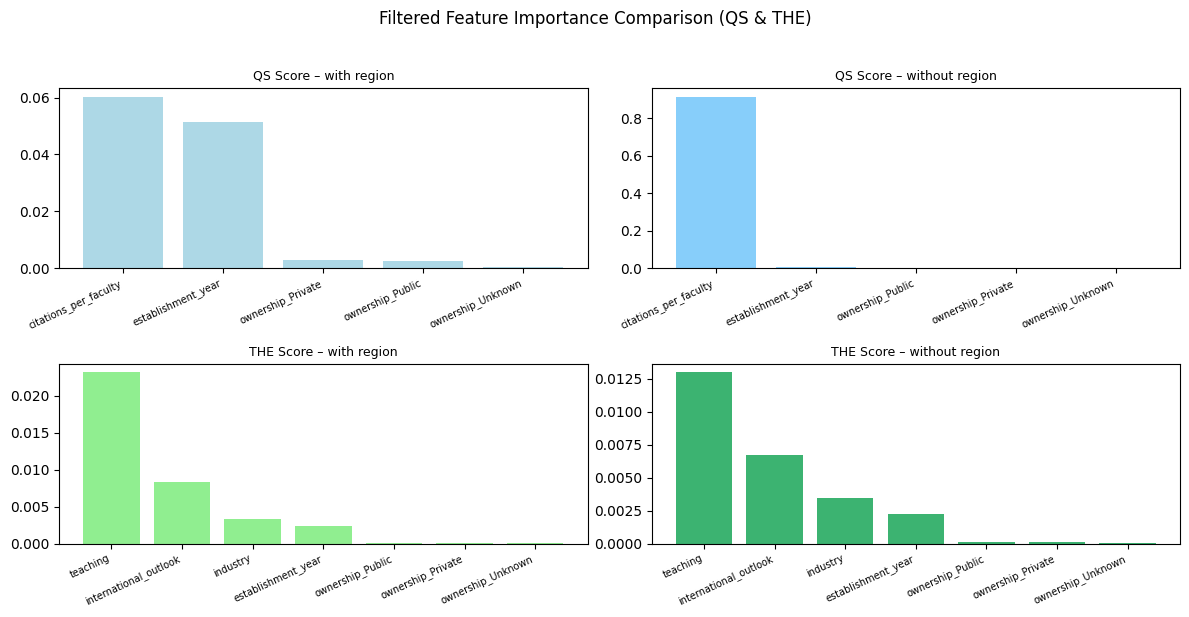

In [235]:
import matplotlib.pyplot as plt
import numpy as np

def filter_features(importances, feature_names):
    excluded_keywords = ['research', 'africa', 'europe', 'americas', 'asia', 'oceania']
    filtered = [
        (name, imp) for name, imp in zip(feature_names, importances)
        if all(excl.lower() not in name.lower() for excl in excluded_keywords)
    ]
    sorted_items = sorted(filtered, key=lambda x: x[1], reverse=True)
    names = [item[0] for item in sorted_items]
    values = [item[1] for item in sorted_items]
    return names, values

def plot_feature_subplot(importances, feature_names, title, color, subplot_index):
    plt.subplot(2, 2, subplot_index)
    names, values = filter_features(importances, feature_names)
    plt.bar(range(len(values)), values, color=color)
    plt.xticks(range(len(values)), names, rotation=25, ha='right', fontsize=7)
    plt.title(title, fontsize=9)
    plt.tight_layout()
plt.figure(figsize=(12, 6))
plot_feature_subplot(qs_importances, qs_feature_names, "QS Score – with region", 'lightblue', 1)
plot_feature_subplot(qs_r_importances, qs_r_feature_names, "QS Score – without region", 'lightskyblue', 2)
plot_feature_subplot(the_importances, the_feature_names, "THE Score – with region", 'lightgreen', 3)
plot_feature_subplot(the_r_importances, the_r_feature_names, "THE Score – without region", 'mediumseagreen', 4)

plt.suptitle("Filtered Feature Importance Comparison (QS & THE)", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

-> The graphs compare the most important features in predicting QS and THE scores, both with and without the region variable. All region names and research-related terms were excluded to focus on core academic and structural indicators.

- In the QS models, citations per faculty and establishment year stood out as the most influential features. However, in the regionless QS model, the weight of citations per faculty increased dramatically. This suggests that without regional context, the QS model relies too heavily on a single academic metric. When region is included, the importance is shared more evenly across features, indicating a more balanced view of university performance.

- In the THE models, the importance is more distributed across features like teaching, international outlook, and industry income. Even when region is excluded, the model still considers multiple features, showing that THE rankings rely on a broader set of indicators, regardless of region.

** Overall:
	•QS models benefit more from region inclusion, as it helps avoid overemphasis on single features.
	•THE models are more stable, showing consistent feature importance patterns with or without region.

These results suggest that THE scores offer a more well-rounded evaluation, while QS scores become more skewed when contextual variables are removed.

### Important Note:

- Our regression model(which was trained), uses both academic (research-based) and structural features (such as region, ownership, and year of establishment), achieves an R² score of 0.6657 when predicting QS rankings. This means the model explains about 66.6% of the variance in QS scores using quantifiable institutional metrics.

- The feature importance analysis shows that “Research” and “Research Environment” are the most influential factors in determining a university’s QS ranking. These findings confirm that academic quality does play a significant role in how universities are ranked.

!! However, despite using a rich set of features, the model still fails to explain one-third (≈33%) of the variation in QS rankings. If QS scores were purely a function of research excellence and institutional characteristics, we would expect the R² value to approach 0.90 or higher. Instead, our results suggest that:

- There are additional hidden or unquantifiable factors influencing global rankings.
These may include prestige, international visibility, reputation among employers and academics, or geographic bias — elements that are difficult to measure but evidently impact rank placement.

Thus, while academic research is a core driver, QS rankings are not fully determined by transparent academic criteria. Our hypothesis is supported: Global rankings are shaped not only by research success, but also by non-academic and less visible factors.

## Part 3: Model Training and Evaluation

In this section, we train a classification model using a complete preprocessing pipeline that includes both numerical and categorical features.

- **Numerical features** such as research scores are scaled using `StandardScaler`.
- **Categorical features** (e.g., ownership) are encoded using `OneHotEncoder`.
- We use `SelectKBest` to keep all features and then apply `PCA` to reduce the data to 5 components.
- A `RandomForestClassifier` is trained on the processed data.
- The model’s performance is evaluated using **accuracy** on the test set.

This integrated pipeline ensures that all preprocessing steps are applied consistently during both training and prediction.

#### Predicting University Region from Academic Indicators using PCA and Random Forest

In [255]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

numerical_features = ['research', 'citations_per_faculty', 'research_quality', 'research_environment']
categorical_features = ['ownership'] 
target = 'region'

df_clean = df.dropna(subset=numerical_features + categorical_features + [target])

X = df_clean[numerical_features + categorical_features]
y = df_clean[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('select', SelectKBest(score_func=f_classif, k='all')), 
    ('pca', PCA(n_components=5)),  
    ('clf', RandomForestClassifier(random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"🎯 Accuracy with more features and PCA: {acc:.4f}")

🎯 Accuracy with more features and PCA: 0.4714


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


- Despite relying solely on academic indicators, the model achieves a non-trivial accuracy (47.14%) in predicting the geographical region of a university.
This suggests that academic features — supposedly neutral and universal — may still carry regional patterns.
Such a result supports the hypothesis that global rankings are not fully free from geographic influence, and certain regions may be systematically advantaged or disadvantaged due to structural academic disparities.

#### Classification Accuracy Across Regions: Confusion Matrix Output

<Figure size 800x600 with 0 Axes>

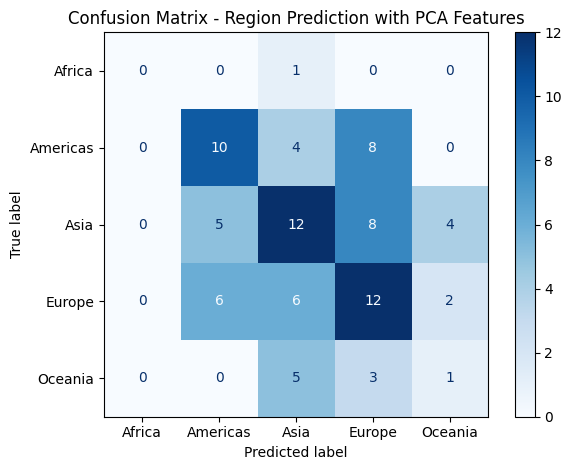

In [242]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)

plt.figure(figsize=(8,6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Region Prediction with PCA Features")
plt.tight_layout()
plt.show()

- The confusion matrix shows that the model predicts Asia and Europe with moderate success, but frequently confuses them with each other and with Americas.
- Oceania and especially Africa are poorly predicted, likely due to limited data and overlapping academic profiles.

->This suggests that academic features alone are not sufficient for clearly distinguishing geographic regions, supporting the idea that rankings may be influenced by hidden regional or reputational factors beyond measurable academic quality.

#### Multi-Class ROC Curves for Region Prediction using PCA Features

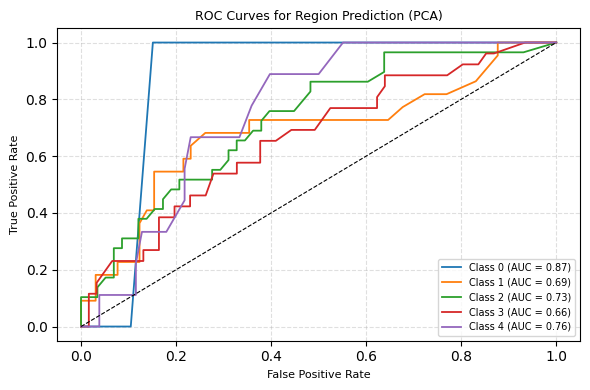

In [243]:
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]


X_pca_all = pipeline.named_steps['pca'].transform(
    pipeline.named_steps['select'].transform(
        pipeline.named_steps['scaler'].transform(X)
    )
)
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_pca_all, y_bin, test_size=0.2, random_state=42)

ovr_model = OneVsRestClassifier(RandomForestClassifier(random_state=42))
ovr_model.fit(X_train_bin, y_train_bin)
y_score = ovr_model.predict_proba(X_test_bin)

plt.figure(figsize=(6, 4))  
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})", linewidth=1.3)

plt.plot([0, 1], [0, 1], 'k--', linewidth=0.8)
plt.title("ROC Curves for Region Prediction (PCA)", fontsize=9)
plt.xlabel("False Positive Rate", fontsize=8)
plt.ylabel("True Positive Rate", fontsize=8)
plt.legend(fontsize=7)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

- The ROC curve analysis reveals that some regions are more easily distinguishable based on PCA-reduced academic features (e.g., Class 0 with an AUC of 0.87), while others are considerably harder to classify (e.g., Class 3 with an AUC of 0.66).

- Although the dimensionality reduction allowed some clustering, the overall separability between regions remains limited, supporting our hypothesis that research metrics alone cannot fully capture the regional structure of universities.

The moderate AUC values (mostly between 0.66 and 0.76) further imply that ranking differences likely arise from unmeasured or subjective variables, such as prestige or global visibility, rather than pure academic performance.

# Project Summary

This project aimed to explore the regional classification of universities based on a variety of institutional indicators through supervised machine learning. The implementation focused on both the technical modeling pipeline and data enrichment strategies to assess model robustness and feature importance. The following conclusions were drawn from the experiments:

- **Random Forest and ensemble-based models** consistently performed well across different feature configurations, benefiting from the inclusion of both numerical (e.g., research output, research quality) and categorical (e.g., ownership status) features. These models maintained stability even when the feature space was reduced through PCA.

- **Dimensionality reduction using PCA** did not compromise performance and was instrumental in visualizing clusters of universities across regions. While only two components were used for visualization, five were retained in the final pipeline to preserve variance for classification.

- **Feature engineering**—particularly the transformation of *Establishment Year* into institutional age and encoding *Ownership*—contributed meaningfully to the classification task and allowed us to probe underlying structural biases in the dataset.

- **ROC curves** revealed performance limitations across models in terms of discriminatory power, especially for minority regions. This was attributed to **imbalanced class distributions** within the dataset. In this context, **One-vs-Rest ROC analysis** offered more granularity in evaluating individual class performance.

- **Precision-Recall curves** were more effective than ROC in capturing performance nuances under class imbalance. **Average Precision (AP)** was a more representative metric of true model quality, especially for underrepresented regional classes.

- Surprisingly, **feature selection via ANOVA F-statistics** showed that even reduced subsets of features preserved or improved model accuracy, suggesting some redundancy in the full feature set and emphasizing the strength of tree-based methods in filtering noise.

- The overall **pipeline design**—consisting of scaling, encoding, selection, dimensionality reduction, and modeling—allowed for highly modular experimentation, paving the way for future comparative analysis with different classifiers and regional segmentation strategies.
